In [1]:
pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-givbfdcp
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-givbfdcp
     |████████████████████████████████| 58 kB 3.6 MB/s eta 0:00:011
     |████████████████████████████████| 244 kB 8.4 MB/s eta 0:00:01
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.3-py3-none-any.whl size=83179 sha256=50e62304a6f50a99b8fbdbe66d68dd48d5822ede3060d89cc9f5548ac8d803c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-psfeijf3/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=5dacb7a5696967e5b1573f0cb1fd709ae514722391836c3cca2ee25c98079e95
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretra

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [3]:
from pathlib import Path

from tqdm.notebook import tqdm

import sys, os, random, time
import numba, cv2, gc
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

from segmentation_models_pytorch.unetplusplus import UnetPlusPlus
import segmentation_models_pytorch as smp

import rasterio
from rasterio.windows import Window

import albumentations as A

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold

%matplotlib inline

In [4]:
def set_seeds(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seeds()

### Setup training variables

In [5]:
DATA_PATH = Path('/home/jupyter/data/')
assert DATA_PATH.exists()

In [6]:
def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    splits = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (splits[0:][::2], splits[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype='uint8')
    for lo, hi in zip(starts, ends):
        img[lo: hi] = 1
    return img.reshape(shape, order='F') # Fortran order reshaping

In [7]:
@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(1)
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if len(points) % 2 == 0:
                points.append(i+1)
            else:
                points.append(i+1 - points[-1])
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

In [8]:
# Check run length encoding starting with 0
assert rle_numba([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [2, 2, 5, 1, 7, 4, 12, 1]
# Check run length encoding starting with 0
assert rle_numba([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [1, 3, 5, 1, 7, 4, 12, 1]

/opt/conda/lib/python3.7/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'pixels' of function 'rle_numba'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-7-313ecb27751d>", line 2:
@numba.njit()
def rle_numba(pixels):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [9]:
def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [10]:
train_df = pd.read_csv(DATA_PATH / 'train.csv', index_col=[0])
train_df

,encoding
id,
2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c,7464094 14 7480273 41 7496453 67 7512632 82 75...
095bf7a1f,113430380 22 113468538 67 113506697 111 113544...
54f2eec69,124601765 36 124632133 109 124662536 147 12469...
1e2425f28,49453112 7 49479881 22 49506657 31 49533433 40...


In [11]:
MASK_PATH = Path('/home/jupyter/ds_cache')
!mkdir {MASK_PATH}

import shutil

def reset_mask_path():
    shutil.rmtree(MASK_PATH)

mkdir: cannot create directory ‘/home/jupyter/ds_cache’: File exists


### Dataset

In [12]:
WINDOW = 1024 # tile size
MIN_OVERLAP = 32
NEW_SIZE = 512 # size after re-size which are fed to the model
THRESHOLD = 0
CONTENT_THRESHOLD = 0.08

In [13]:

# Used to filter tiles with enough color information in it
def is_tile_contains_info(img, pixel_limits = (50, 220), content_threshold = CONTENT_THRESHOLD, expected_shape = (WINDOW, WINDOW, 3)):
    """
    img: np.array
    pixel_limits: tuple
    content_threshold: float percents
    expected_shape: tuple
    """
    
    left_limit = np.prod(img > pixel_limits[0], axis=-1)
    right_limit =  np.prod(img < pixel_limits[1], axis=-1)

    if img.shape != expected_shape:
        print('img.shape != expected_shape', img.shape)
        return False, 0.

    percent_of_pixels = np.sum(left_limit*right_limit) / (img.shape[0] * img.shape[1])
    return  percent_of_pixels > content_threshold, percent_of_pixels

In [14]:
# identity = rasterio.Affine(1, 0, 0, 0, 1, 0)
identity = None
# normalize_transform = T.Normalize([0.625, 0.448, 0.688], [0.131, 0.177, 0.101])
# normalize_transform = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# normalize_transform = T.Normalize([0.65459856,0.48386562,0.69428385], [0.15167958,0.23584107,0.13146145])
normalize_transform = T.Normalize([0.6130, 0.4126, 0.6595], [0.1417, 0.2045, 0.1237])

def read_from_slice(dataset, x1, x2, y1, y2):
    image = dataset.read([1,2,3],
                    window=Window.from_slices((x1,x2),(y1,y2)))
    image = np.moveaxis(image, 0, -1)
    return image

class HubDataset(D.Dataset):
    def __init__(self, root_dir, transform, window=256, overlap=32, threshold = THRESHOLD):
        self.path = root_dir
        assert self.path.exists()
        self.overlap, self.window, self.transform, self.threshold = overlap, window, transform, threshold
        self.csv = pd.read_csv(self.path / 'train.csv', index_col=[0])
        self.build_slices()
        self.len = len(self.slices)
        # where do these numbers come from?
        # Better to calculate them to check if correct.
        self.as_tensor = T.Compose([
            T.ToTensor(),
            normalize_transform,
        ])
        
        
    def build_slices(self):
        self.masks = []; self.files = []; self.slices = []
        self.skipped = 0
        slices_path = MASK_PATH/f'slices.pkl'
        files_path = MASK_PATH/f'files.pkl'
        masks_path = MASK_PATH/f'masks.pkl'
        if not slices_path.exists():
            for i, filename in tqdm(enumerate(self.csv.index), total = len(self.csv)):
                filepath = self.path/'train'/f'{filename}.tiff'
                assert filepath.exists()
                self.files.append(filepath)
                with rasterio.open(filepath) as dataset:
                    self.build_slice(dataset, filename, i)
            with open(slices_path, "wb") as filehandler:
                pickle.dump(self.slices, filehandler)
            with open(files_path, "wb") as filehandler:
                pickle.dump(self.files, filehandler)
            with open(masks_path, "wb") as filehandler:
                pickle.dump(self.masks, filehandler)
        else:
            print('Reading cached slices, files and masks')
            with open(slices_path,'rb') as file:
                self.slices = pickle.load(file)
            with open(files_path,'rb') as file:
                self.files = pickle.load(file)
            with open(masks_path,'rb') as file:
                self.masks = pickle.load(file)
                        
    def build_slice(self, dataset, filename, i):
        dataset_shape = dataset.shape
        self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset_shape))
        slices = make_grid(dataset_shape, window = self.window, min_overlap = self.overlap)

        # Shifting slices to the right and bottom and adding to the original slices
        slices_copy = slices.copy()
        slices_copy_y = slices.copy()
#         # horizontal
        slices_copy[:,(0,1)] += WINDOW // 2 # shift
        slices = np.concatenate ([slices, slices_copy])
#         # vertical
        slices_copy_y[:,(2,3)] += WINDOW // 2
        slices = np.concatenate ([slices, slices_copy_y])
        slices = slices[~(slices[:,1] > dataset.shape[0]),:] # filter those outside of the screen
        slices = slices[~(slices[:,3] > dataset.shape[1]),:] # filter those outside of the screen

        # Only including slices above a specific threshold
        # Note: we are potentially throwing away some data here
        for slc in slices:
            x1, x2, y1, y2 = slc
            image = read_from_slice(dataset, x1, x2 , y1, y2)
            contains_info = is_tile_contains_info(image)
            if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold and contains_info[0]:
                self.slices.append([i,x1,x2,y1,y2])
            else:
                self.skipped += 1
                        
                        
    def apply_transform(self, image, mask):
        augments = self.transform(image=image, mask=mask)
        image = self.as_tensor(augments['image'])
        mask = augments['mask'][None]
        return image, mask
        
    def __getitem__(self, index):
        image_path = MASK_PATH/f'image_{index}'
        mask_path = MASK_PATH/f'mask_{index}'
        if not image_path.exists():
            idx = self.slices[index][0]
            filename = self.files[idx]
            x1, x2, y1, y2 = self.slices[index][1:]
            with rasterio.open(filename) as dataset:
                image = read_from_slice(dataset, x1, x2, y1, y2).astype('uint8')
            mask = self.masks[idx][x1:x2,y1:y2]
            with open(image_path, "wb") as filehandler:
                pickle.dump(image, filehandler)
                if index % 100 == 0:
                    print(f'Writing to {image_path}')
            with open(mask_path, "wb") as filehandler:
                pickle.dump(mask, filehandler)
            return self.apply_transform(image, mask)
        else:
            with open(image_path,'rb') as file:
                image = pickle.load(file)
            with open(mask_path,'rb') as file:
                mask = pickle.load(file)
            return self.apply_transform(image, mask)
    
    def __len__(self):
        return self.len
    
    def __repr__(self):
        return f'total: {len(self)}, skipped: {self.skipped}'

In [15]:
reset_mask_path()
!mkdir {MASK_PATH}

In [16]:
def generate_ds(size):
    trfm = A.Compose([
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ColorJitter (brightness=0.07, contrast=0.07,
                       saturation=0.1, hue=0.1, always_apply=False, p=0.3),
        A.OneOf(
            [
                A.Rotate(limit = (90, 90), p=1),
                A.Rotate(limit = (-90, -90), p=1)
            ],
            p=0.3
        ),
        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
                A.RandomBrightness(p=1)
            ],
            p=0.5,
        )
    ])

    return HubDataset(DATA_PATH, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm)

ds = generate_ds(NEW_SIZE)

  0%|          | 0/8 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [17]:
ds

total: 5334, skipped: 16706

In [34]:
# with rasterio.open('/home/jupyter/data/train/2f6ecfcdf.tiff') as raster:
#     img = raster.read([1,2,3], window=Window.from_slices((3909, 4933),(11464,12488)))
#     img = np.moveaxis(img, 0, -1)
#     print(img.shape)
#     crs = raster.crs

# plt.figure(figsize = (20,20))
# plt.imshow(img)
# plt.show()


In [35]:
# translation_matrix = np.float32([ [1, 0, WINDOW // 2], [0, 1, WINDOW // 2] ])
# img = cv2.warpAffine(img, translation_matrix, (img.shape[1], img.shape[0]))

In [18]:
# plt.figure(figsize = (20,20))
# plt.imshow(img)
# plt.show()

In [19]:
# slices = make_grid(raster.shape, window = WINDOW, min_overlap = MIN_OVERLAP)
# slices.shape

In [20]:
# slices_copy_y = slices.copy()
# slices_copy_y[:,(2,3)] += WINDOW // 2
# slices_copy_y = slices_copy_y[~(slices_copy[:,3] > raster.shape[1]),:]
# slices = np.concatenate ([slices, slices_copy_y])

Writing to /home/jupyter/ds_cache/image_0


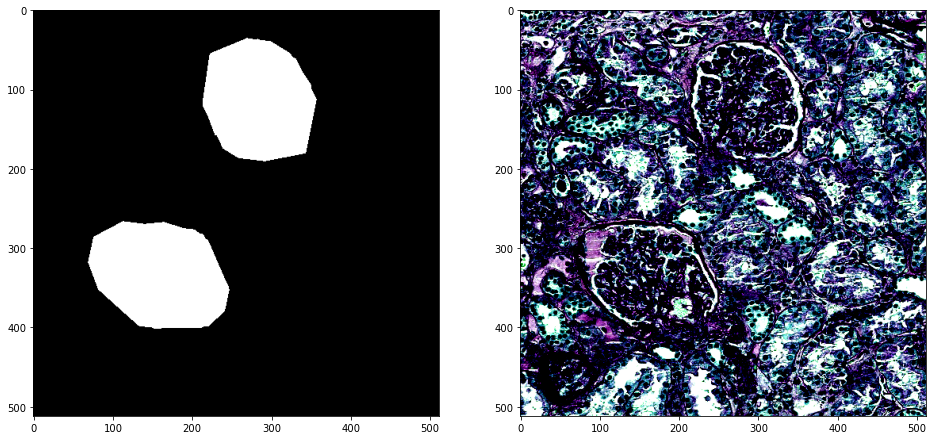

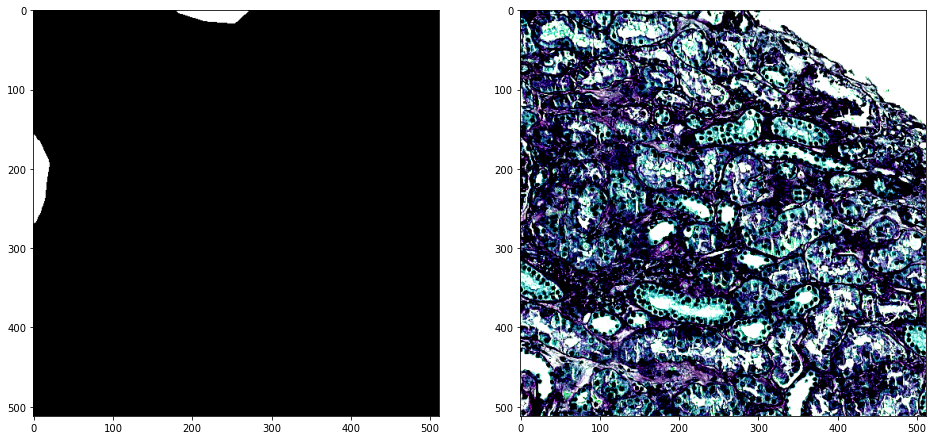

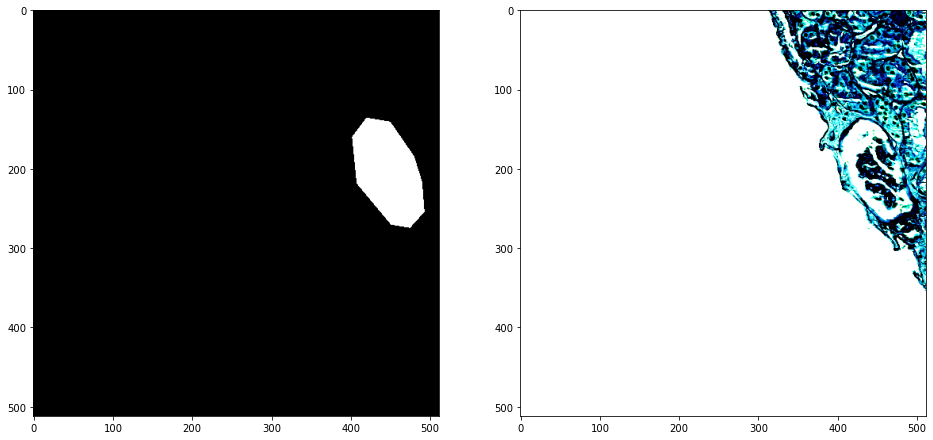

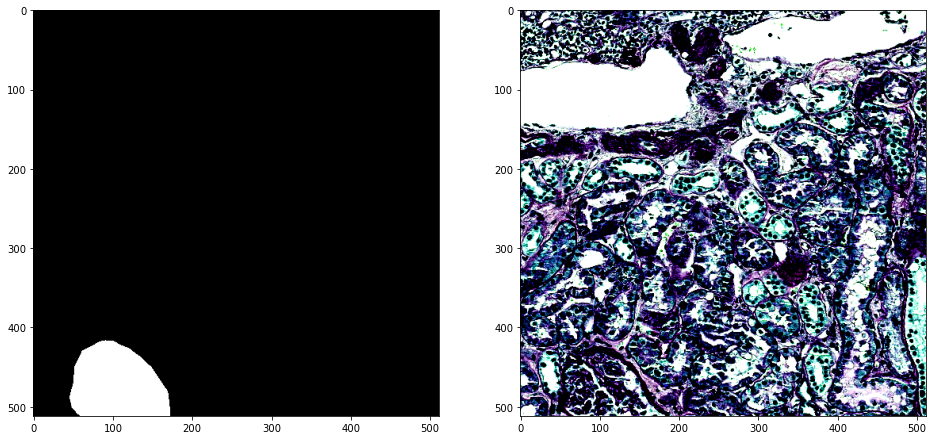

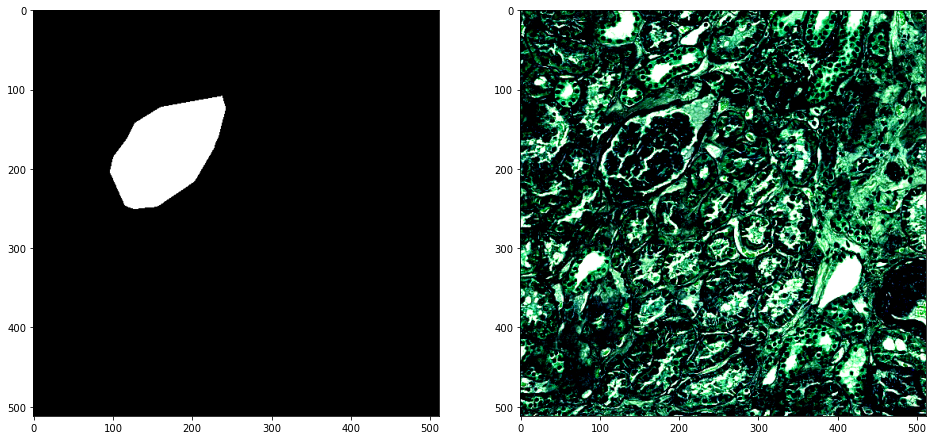

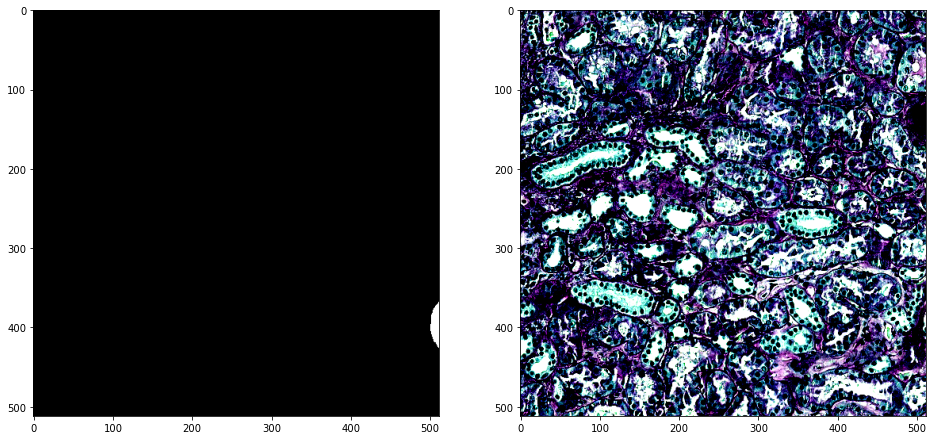

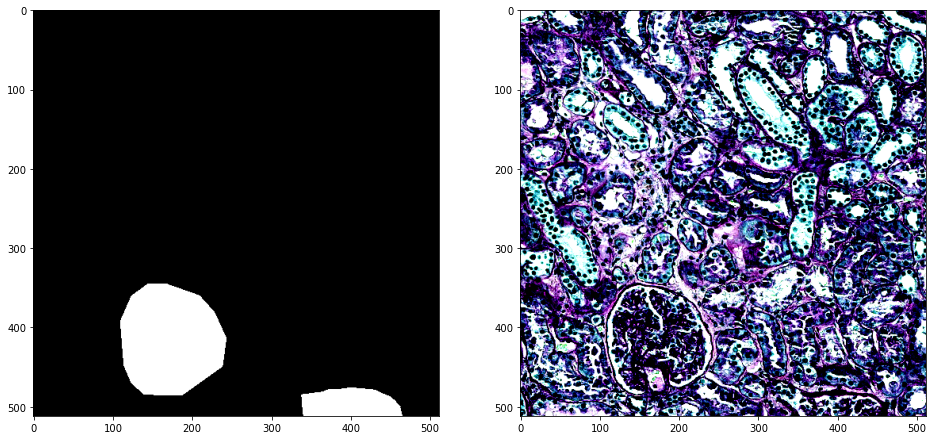

In [30]:
def display_mask_img(idx):
    image, mask = ds[idx]
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.imshow(mask[0], cmap='gray')
    plt.subplot(122)
    plt.imshow(np.moveaxis(image.numpy(), 0, -1));

display_mask_img(2)
display_mask_img(1)
display_mask_img(0)
display_mask_img(3)
display_mask_img(5)
display_mask_img(6)
display_mask_img(7)

In [31]:
image, mask = ds[0]

_ = rle_numba_encode(mask[0]) # compile function with numba

#### Split

In [42]:
FOLDS = 4

In [43]:
# Images and its corresponding masks are saved with the same filename.
groups = [ds.slices[i][0] for i in range(len(ds))]

In [44]:
# ds.slices

In [45]:
group_kfold = GroupKFold(n_splits = FOLDS)

In [46]:
def create_split_on_index(img_index = 7):
    valid_idx, train_idx = [], []
    for i in range(len(ds)):
        if ds.slices[i][0] == img_index:
            valid_idx.append(i)
        else:
            train_idx.append(i)
    return valid_idx, train_idx

#### Data loaders

In [47]:
BATCH_SIZE = 8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [48]:
def generate_train_valid_dls(ds, train_idx, valid_idx):
    train_ds = D.Subset(ds, train_idx)
    valid_ds = D.Subset(ds, valid_idx)

    # define training and validation data loaders
    train_dl = D.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    valid_dl = D.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    return train_dl, valid_dl

In [49]:
fold_info = [(train_idx, valid_idx) for fold, (train_idx, valid_idx) in tqdm(enumerate(group_kfold.split(ds.slices, 
                                                        groups = groups)), total=FOLDS)]
sample_train_dl, sample_valid_dl = generate_train_valid_dls(ds, fold_info[0][0], fold_info[0][1])

  0%|          | 0/4 [00:00<?, ?it/s]

In [50]:
sample_image, sample_mask = next(iter(sample_train_dl))

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [51]:
sample_image.shape, sample_mask.shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 1, 512, 512]))

### Model

In [52]:
ENCODER_NAME = 'efficientnet-b6'

class HuBMAPModel(nn.Module):
    def __init__(self):
        super(HuBMAPModel, self).__init__()
        self.model = UnetPlusPlus(encoder_name = ENCODER_NAME, 
                          encoder_weights = 'imagenet',
                          classes = 1,
                          activation = None)
        
        
    def forward(self, images):
        img_masks = self.model(images)
        return img_masks

In [53]:
def get_model():
    model = HuBMAPModel()
    return model

### Training

In [54]:
LR = 1e-3
WD = 1e-3
BEST_MODEL = f'best_model_unet_1024_double_shift_grad_acc_{ENCODER_NAME}.pth'

In [55]:
def create_optimizer_scheduler(model, train_dl, epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                    steps_per_epoch=len(train_dl), epochs=epochs)
    return optimizer, scheduler

### Loss

In [56]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.5 * bce + 0.5 * dice

In [57]:
dice_loss = smp.utils.losses.DiceLoss()

def loss_fn(y_pred, y_true):
    return dice_loss(y_pred.sigmoid(), y_true)

In [58]:
jaccard_loss = smp.utils.losses.JaccardLoss()

def loss_fn(y_pred, y_true):
    return jaccard_loss(y_pred.sigmoid(), y_true)

In [59]:
def dice_metric(y_pred, y, epsilon = 1.0):
    dims=(-2,-1)
    x = (y_pred > 0).float()
    dc = (2 * (x * y).sum(dims)) / ((x + y).sum(dims) + epsilon)
    return dc.mean()

In [60]:
iou_metric = smp.utils.metrics.IoU(threshold=0.5)

In [61]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_epoch(model, dataloader, optim, criterion, scheduler, device="cpu", grad_accu_steps=4):
    model.train()
    
    train_loss = []
    labels = []
    outs = []
    lrs = []
    
    tbar = tqdm(dataloader)
    scaler = torch.cuda.amp.GradScaler() # mixed precision support
    scale = None
    for step, (image, target) in enumerate(tbar):
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        
        with torch.cuda.amp.autocast():
            output = model(image)
            loss = criterion(output, target) / grad_accu_steps
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        if (step + 1) % grad_accu_steps == 0:
            scaler.step(optim)
            scale = scaler.get_scale()
            scaler.update()
            optim.zero_grad()
        
        skip_lr_sched = (scale != scaler.get_scale())
        if not skip_lr_sched:
            scheduler.step()
        
        loss_val = loss.item() * grad_accu_steps
        train_loss.append(loss_val)
        lrs.append(get_lr(optim))
        
        tbar.set_description('loss - {:.4f}'.format(loss_val))
        
    print(f'Train loss: {np.array(train_loss).mean()}')
    return train_loss, lrs

In [62]:
def val_epoch(model, dataloader, criterion, epoch, device="cpu"):
    model.eval()

    valid_loss = []
    num_corrects = 0
    num_total = 0
    labels = []
    outs = []
    dice_metrics = []
    iou_metrics = []

    for item in dataloader:
        image, target = item
        image, target = image.to(DEVICE), target.float().to(DEVICE)

        with torch.no_grad():
            output = model(image)
            loss = criterion(output, target)
            dice_metrics.append(dice_metric(output, target))
            iou_metrics.append(iou_metric(output, target))
        valid_loss.append(loss.item())

    avg_loss = np.array(valid_loss).mean()
    print(f'Epoch {epoch} - valid loss: {avg_loss}')
    dice_metrics = [x.item() for x in dice_metrics]
    iou_metrics = [x.item() for x in iou_metrics]
    dice_metric_mean = np.array(dice_metrics).mean()
    iou_metric_mean = np.array(iou_metrics).mean()
    return dice_metrics, valid_loss, dice_metric_mean, avg_loss, iou_metric_mean

In [63]:
def train(epochs, train_dl, valid_dl, optimizer, scheduler, patience = 6):
    best_loss = 100.0
    best_metric = 0
    train_losses = []
    valid_losses = []
    accumulated_lrs = []
    accumulated_dice_metrics = []
    early_stop_counter = 0

    for epoch in tqdm(range(epochs)):
        train_loss, lrs = train_epoch(model, train_dl, optimizer, loss_fn, scheduler, DEVICE)
        dice_metrics, valid_loss, dice_metric_mean, avg_loss, iou_metric_mean = val_epoch(model, valid_dl, loss_fn, epoch, DEVICE)
        train_losses += train_loss
        valid_losses.append(np.array(valid_loss).mean())
        accumulated_lrs += lrs
        accumulated_dice_metrics.append(np.array(dice_metrics).mean())
        if best_metric < iou_metric_mean:
            best_metric = iou_metric_mean
            print('Saving model')
            torch.save(model.state_dict(), BEST_MODEL)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        if best_loss > avg_loss:
            best_loss = avg_loss
        print(f'Epoch {epoch} - val best loss {best_loss} dice metric ({dice_metric_mean}) iou metric ({iou_metric_mean}).')
        if early_stop_counter >= patience:
            print('Stopping early')
            break
        
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [64]:
# reset_mask_path()
# !mkdir {MASK_PATH}

In [65]:
EPOCHS = 8
PATIENCE = 5

In [66]:
def train_split(fold_info, fold):
    global model
    
    print(f'Processing fold {fold}')
    model = get_model()
    model.to(DEVICE)
    train_idx, valid_idx = fold_info[fold]
    f'Proportions valid / train: {len(valid_idx) / len(train_idx)}'
    train_dl, valid_dl = generate_train_valid_dls(ds, train_idx, valid_idx)
    optimizer, scheduler = create_optimizer_scheduler(model, train_dl, EPOCHS)
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train(EPOCHS, train_dl, valid_dl, optimizer, scheduler, patience = PATIENCE)
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [67]:
train_idx, valid_idx = fold_info[0]
train_dl, valid_dl = generate_train_valid_dls(ds, train_idx, valid_idx)
for image, target in tqdm(train_dl):
    pass
#     assert image.shape[0] > 1
for image, target in tqdm(valid_dl):
    pass
#     assert image.shape[0] > 1

  0%|          | 0/506 [00:00<?, ?it/s]

Writing to /home/jupyter/ds_cache/image_5100
Writing to /home/jupyter/ds_cache/image_500
Writing to /home/jupyter/ds_cache/image_1800
Writing to /home/jupyter/ds_cache/image_1000
Writing to /home/jupyter/ds_cache/image_300
Writing to /home/jupyter/ds_cache/image_1500
Writing to /home/jupyter/ds_cache/image_2700
Writing to /home/jupyter/ds_cache/image_1300
Writing to /home/jupyter/ds_cache/image_4900
Writing to /home/jupyter/ds_cache/image_400
Writing to /home/jupyter/ds_cache/image_5000
Writing to /home/jupyter/ds_cache/image_4800
Writing to /home/jupyter/ds_cache/image_4400
Writing to /home/jupyter/ds_cache/image_0
Writing to /home/jupyter/ds_cache/image_5300
Writing to /home/jupyter/ds_cache/image_900
Writing to /home/jupyter/ds_cache/image_600
Writing to /home/jupyter/ds_cache/image_1900
Writing to /home/jupyter/ds_cache/image_4600
Writing to /home/jupyter/ds_cache/image_2600
Writing to /home/jupyter/ds_cache/image_4700
Writing to /home/jupyter/ds_cache/image_2100
Writing to /home/j

  0%|          | 0/162 [00:00<?, ?it/s]

Writing to /home/jupyter/ds_cache/image_2800
Writing to /home/jupyter/ds_cache/image_2900
Writing to /home/jupyter/ds_cache/image_3000
Writing to /home/jupyter/ds_cache/image_3100
Writing to /home/jupyter/ds_cache/image_3200
Writing to /home/jupyter/ds_cache/image_3300
Writing to /home/jupyter/ds_cache/image_3400
Writing to /home/jupyter/ds_cache/image_3500
Writing to /home/jupyter/ds_cache/image_3600
Writing to /home/jupyter/ds_cache/image_3700
Writing to /home/jupyter/ds_cache/image_3800
Writing to /home/jupyter/ds_cache/image_3900
Writing to /home/jupyter/ds_cache/image_4000


In [68]:
def train_split_and_move(fold_info, fold):
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train_split(fold_info, fold)
    !mv {BEST_MODEL} {fold}_{BEST_MODEL}
    stats_df = pd.DataFrame({'train_losses': train_losses, 'accumulated_lrs': accumulated_lrs})
    stats_df[['train_losses']].plot()
    val_stats_df = pd.DataFrame({'valid_losses': valid_losses})
    val_stats_df[['valid_losses']].plot()

Processing fold 0


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

Train loss: 0.8752559310362744
Epoch 0 - valid loss: 0.7297982838418748
Saving model
Epoch 0 - val best loss 0.7297982838418748 dice metric (0.4817325717505114) iou metric (0.3810657196574741).


  0%|          | 0/506 [00:00<?, ?it/s]

Train loss: 0.40638372761458746
Epoch 1 - valid loss: 0.26070521275202435
Saving model
Epoch 1 - val best loss 0.26070521275202435 dice metric (0.7477134182865237) iou metric (0.7482468649561023).


  0%|          | 0/506 [00:00<?, ?it/s]

Train loss: 0.20509987091829654
Epoch 2 - valid loss: 0.23755622167646148
Saving model
Epoch 2 - val best loss 0.23755622167646148 dice metric (0.7592861501523006) iou metric (0.7638357414139642).


  0%|          | 0/506 [00:00<?, ?it/s]

Train loss: 0.18634418819261633
Epoch 3 - valid loss: 0.24305138065491194
Epoch 3 - val best loss 0.23755622167646148 dice metric (0.7502810668062281) iou metric (0.7573677242538075).


  0%|          | 0/506 [00:00<?, ?it/s]

Train loss: 0.17664409001825354
Epoch 4 - valid loss: 0.23560141523679098
Saving model
Epoch 4 - val best loss 0.23560141523679098 dice metric (0.7588709876125241) iou metric (0.7647298427275669).


  0%|          | 0/506 [00:00<?, ?it/s]

Train loss: 0.16600825935013208
Epoch 5 - valid loss: 0.22890488159509353
Saving model
Epoch 5 - val best loss 0.22890488159509353 dice metric (0.780951460202535) iou metric (0.7713541346199718).


  0%|          | 0/506 [00:00<?, ?it/s]

Train loss: 0.15938496471864905
Epoch 6 - valid loss: 0.22465716946272202
Saving model
Epoch 6 - val best loss 0.22465716946272202 dice metric (0.7847450250460778) iou metric (0.7755335977783909).


  0%|          | 0/506 [00:00<?, ?it/s]

Train loss: 0.1537503749721135
Epoch 7 - valid loss: 0.22624629735946655
Epoch 7 - val best loss 0.22465716946272202 dice metric (0.7840546446817892) iou metric (0.7740308020585849).


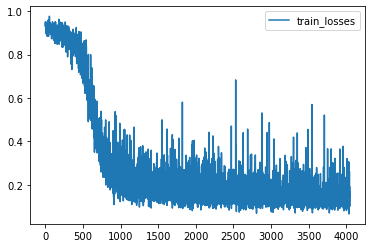

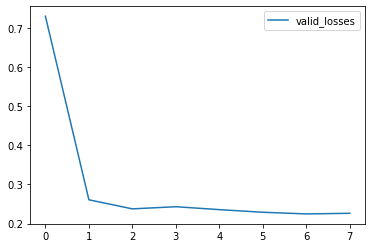

In [69]:
train_split_and_move(fold_info, 0)

Processing fold 1


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

Train loss: 0.8794516595380921
Epoch 0 - valid loss: 0.7905309720094814
Saving model
Epoch 0 - val best loss 0.7905309720094814 dice metric (0.46636169507753017) iou metric (0.36838195178397865).


  0%|          | 0/496 [00:00<?, ?it/s]

Train loss: 0.451406043022871
Epoch 1 - valid loss: 0.2053155763897785
Saving model
Epoch 1 - val best loss 0.2053155763897785 dice metric (0.8030389599328818) iou metric (0.8196557514196219).


  0%|          | 0/496 [00:00<?, ?it/s]

Train loss: 0.24526550969289196
Epoch 2 - valid loss: 0.16058467397856158
Saving model
Epoch 2 - val best loss 0.16058467397856158 dice metric (0.839463013202645) iou metric (0.8435153482958327).


  0%|          | 0/496 [00:00<?, ?it/s]

Train loss: 0.223235217193442
Epoch 3 - valid loss: 0.16047640803248384
Epoch 3 - val best loss 0.16047640803248384 dice metric (0.8277407843013143) iou metric (0.8420858580705731).


  0%|          | 0/496 [00:00<?, ?it/s]

Train loss: 0.20401778865245082
Epoch 4 - valid loss: 0.13742713352968527
Saving model
Epoch 4 - val best loss 0.13742713352968527 dice metric (0.855836215753888) iou metric (0.8644154990135238).


  0%|          | 0/496 [00:00<?, ?it/s]

Train loss: 0.19783160619197354
Epoch 5 - valid loss: 0.13583368929319603
Saving model
Epoch 5 - val best loss 0.13583368929319603 dice metric (0.8541851050631944) iou metric (0.8654632523309352).


  0%|          | 0/496 [00:00<?, ?it/s]

Train loss: 0.18843040987849236
Epoch 6 - valid loss: 0.13457088934820752
Saving model
Epoch 6 - val best loss 0.13457088934820752 dice metric (0.8586832257204278) iou metric (0.866761737784674).


  0%|          | 0/496 [00:00<?, ?it/s]

Train loss: 0.18694747732050956
Epoch 7 - valid loss: 0.13055273232071898
Saving model
Epoch 7 - val best loss 0.13055273232071898 dice metric (0.8639443894458372) iou metric (0.8707238401091376).


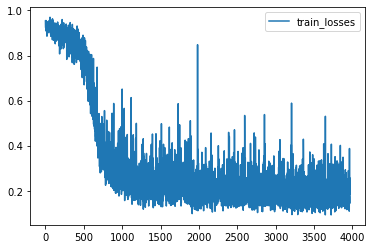

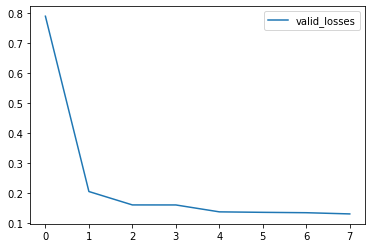

In [70]:
train_split_and_move(fold_info, 1)

Processing fold 2


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

Train loss: 0.8725635600321501
Epoch 0 - valid loss: 0.8164842556181707
Saving model
Epoch 0 - val best loss 0.8164842556181707 dice metric (0.3924465954401775) iou metric (0.2875166816980039).


  0%|          | 0/515 [00:00<?, ?it/s]

Train loss: 0.48130929250161625
Epoch 1 - valid loss: 0.26396892768772023
Saving model
Epoch 1 - val best loss 0.26396892768772023 dice metric (0.7311479239479491) iou metric (0.7617977675246564).


  0%|          | 0/515 [00:00<?, ?it/s]

Train loss: 0.22970189955628034
Epoch 2 - valid loss: 0.20557312549729095
Saving model
Epoch 2 - val best loss 0.20557312549729095 dice metric (0.7839566145680452) iou metric (0.7990230419918111).


  0%|          | 0/515 [00:00<?, ?it/s]

Train loss: 0.20548904925874137
Epoch 3 - valid loss: 0.1881137580463761
Saving model
Epoch 3 - val best loss 0.1881137580463761 dice metric (0.7848359075816054) iou metric (0.8135947049840501).


  0%|          | 0/515 [00:00<?, ?it/s]

Train loss: 0.19231585241058496
Epoch 4 - valid loss: 0.1808188424298638
Saving model
Epoch 4 - val best loss 0.1808188424298638 dice metric (0.8006864101871064) iou metric (0.8205712053336596).


  0%|          | 0/515 [00:00<?, ?it/s]

Train loss: 0.18416403288980132
Epoch 5 - valid loss: 0.1753788939432094
Saving model
Epoch 5 - val best loss 0.1753788939432094 dice metric (0.7994967175549582) iou metric (0.8254094037570452).


  0%|          | 0/515 [00:00<?, ?it/s]

Train loss: 0.17753195820502865
Epoch 6 - valid loss: 0.1773889809846878
Epoch 6 - val best loss 0.1753788939432094 dice metric (0.7922207319030636) iou metric (0.8233227411187009).


  0%|          | 0/515 [00:00<?, ?it/s]

Train loss: 0.17324043165132838
Epoch 7 - valid loss: 0.17483269187964892
Saving model
Epoch 7 - val best loss 0.17483269187964892 dice metric (0.7983672191437922) iou metric (0.8258991200280817).


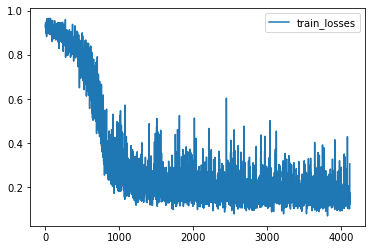

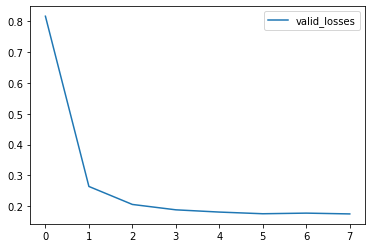

In [71]:
train_split_and_move(fold_info, 2)

Processing fold 3


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

Train loss: 0.8870220140083549
Epoch 0 - valid loss: 0.823174312547013
Saving model
Epoch 0 - val best loss 0.823174312547013 dice metric (0.39344162637224567) iou metric (0.29858690459322146).


  0%|          | 0/485 [00:00<?, ?it/s]

Train loss: 0.4781862022950477
Epoch 1 - valid loss: 0.31566262114179006
Saving model
Epoch 1 - val best loss 0.31566262114179006 dice metric (0.7217381296904533) iou metric (0.7001909161662008).


  0%|          | 0/485 [00:00<?, ?it/s]

Train loss: 0.22096259286723186
Epoch 2 - valid loss: 0.24903371995621984
Saving model
Epoch 2 - val best loss 0.24903371995621984 dice metric (0.731987870656527) iou metric (0.7537164522723837).


  0%|          | 0/485 [00:00<?, ?it/s]

Train loss: 0.18954048574585275
Epoch 3 - valid loss: 0.26335796320831384
Epoch 3 - val best loss 0.24903371995621984 dice metric (0.7242153450682923) iou metric (0.7374569035165912).


  0%|          | 0/485 [00:00<?, ?it/s]

Train loss: 0.1805708832347516
Epoch 4 - valid loss: 0.2224188080200782
Saving model
Epoch 4 - val best loss 0.2224188080200782 dice metric (0.7720154006402571) iou metric (0.7786799083044241).


  0%|          | 0/485 [00:00<?, ?it/s]

Train loss: 0.16916762639566796
Epoch 5 - valid loss: 0.2405658475645296
Epoch 5 - val best loss 0.2224188080200782 dice metric (0.7419116051642449) iou metric (0.7595213618907299).


  0%|          | 0/485 [00:00<?, ?it/s]

Train loss: 0.1643833213245746
Epoch 6 - valid loss: 0.2215305311339242
Saving model
Epoch 6 - val best loss 0.2215305311339242 dice metric (0.7686122917866969) iou metric (0.7787863990435233).


  0%|          | 0/485 [00:00<?, ?it/s]

Train loss: 0.16086471572364727
Epoch 7 - valid loss: 0.22153028976786268
Saving model
Epoch 7 - val best loss 0.22153028976786268 dice metric (0.7754118005325507) iou metric (0.7788997628204115).


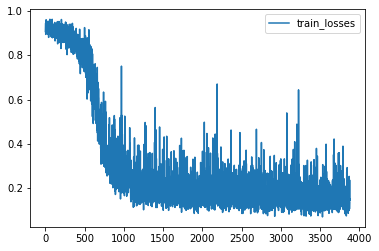

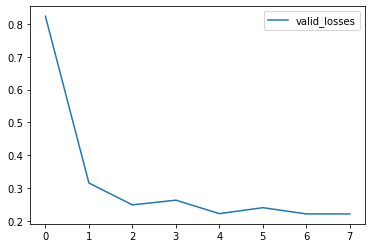

In [72]:
train_split_and_move(fold_info, 3)

In [ ]:
!mv *.pth models